In [1]:
import pandas as pd
import scipy
import numpy as np
import scipy.sparse as sp
import scipy.io as spio

import operator
import matplotlib.pyplot as plt


def plot_cut_2mers(datafr, cut_mat) :
    cut_mer2 = {}

    seqs = list(datafr['seq'].values)
    seqs = np.array(seqs, dtype=np.object)

    total_count = np.array(datafr['total_count'])

    cx = sp.coo_matrix(cut_mat)

    for i,j,v in zip(cx.row, cx.col, cx.data) :
        seq = seqs[i]

        mer2 = seq[j-1:j+1]
        if mer2 not in cut_mer2 :
            cut_mer2[mer2] = 0
        cut_mer2[mer2] += v

    cut_mer2_sorted = sorted(cut_mer2.items(), key=operator.itemgetter(1))

    mer2_list = []
    mer2_vals = []
    for i in range(0, len(cut_mer2_sorted)) :
        mer2_list.append(cut_mer2_sorted[i][0])
        mer2_vals.append(cut_mer2_sorted[i][1])

    f = plt.figure(figsize=(6, 4))

    plt.bar(mer2_list, mer2_vals, color='black')

    plt.title('Proximal cleavage dinuc.', fontsize=14)
    plt.xlabel('Dinucleotide', fontsize=14)
    plt.ylabel('Read count', fontsize=14)

    plt.xticks(fontsize=14, rotation=45)
    plt.yticks(fontsize=14)

    plt.tight_layout()
    plt.show()

In [2]:
library_name = 'apasix_noacut'
library_version = 'unfiltered'

In [3]:
raw_data_name = 'apasix'
data = pd.read_csv(raw_data_name + '.csv', sep=',').reset_index(drop=True)

In [4]:
emitted_proximal_count = []
emitted_distal_count = []
emitted_total_count = []
emitted_seq = []
emitted_mask = []
emitted_lib = []
emitted_lib_index = []
emitted_sublib = []
emitted_sublib_index = []

proximal_cuts = sp.lil_matrix((len(data), 206)) #PAS CSE starts at 60


lib_dict = {}
lib_dict['aar'] = 0
lib_dict['atr'] = 1
lib_dict['hsp'] = 2
lib_dict['snh'] = 3
lib_dict['sox'] = 4
lib_dict['wha'] = 5

up_alignmentl = [
    34,
    29,
    34,
    22,
    37,
    33
]

up_constantl = [
    'CCTCCTCCGAGCGGATGTACCCCGAGGACGGCGCCCTGAAGGGCGAGATCAAGCAGAGGCTGAAGCTGAAGGACGGCGGCCACTACGACGCTGAGGTCAAGACCACCTACAAGGCCAAGAAGCCCGTGCAGCTGCCCGGCGCCTACAACGTCAACATCAAGTTGGACATCACCTCCCACAACGAGGACTACACCATCGTGGAACAGTACGAACGCGCCGAGGGCCGCCACTCCACCGGCGGCATGGACGAGCTGTACAAGTCTTGATCCCTACACGACGCTCTTCCGATCTCTGAGCTTT',
    'CTCCTCCGAGCGGATGTACCCCGAGGACGGCGCCCTGAAGGGCGAGATCAAGCAGAGGCTGAAGCTGAAGGACGGCGGCCACTACGACGCTGAGGTCAAGACCACCTACAAGGCCAAGAAGCCCGTGCAGCTGCCCGGCGCCTACAACGTCAACATCAAGTTGGACATCACCTCCCACAACGAGGACTACACCATCGTGGAACAGTACGAACGCGCCGAGGGCCGCCACTCCACCGGCGGCATGGACGAGCTGTACAAGTCTTGATCCCTACACGACGCTCTTCCGATCTAATGCATTTG',
    'CTCCTCCGAGCGGATGTACCCCGAGGACGGCGCCCTGAAGGGCGAGATCAAGCAGAGGCTGAAGCTGAAGGACGGCGGCCACTACGACGCTGAGGTCAAGACCACCTACAAGGCCAAGAAGCCCGTGCAGCTGCCCGGCGCCTACAACGTCAACATCAAGTTGGACATCACCTCCCACAACGAGGACTACACCATCGTGGAACAGTACGAACGCGCCGAGGGCCGCCACTCCACCGGCGGCATGGACGAGCTGTACAAGTCTTGATCCCTACACGACGCTCTTCCGATCTTCTGAAATCT',
    'CTCCTCCGAGCGGATGTACCCCGAGGACGGCGCCCTGAAGGGCGAGATCAAGCAGAGGCTGAAGCTGAAGGACGGCGGCCACTACGACGCTGAGGTCAAGACCACCTACAAGGCCAAGAAGCCCGTGCAGCTGCCCGGCGCCTACAACGTCAACATCAAGTTGGACATCACCTCCCACAACGAGGACTACACCATCGTGGAACAGTACGAACGCGCCGAGGGCCGCCACTCCACCGGCGGCATGGACGAGCTGTACAAGTCTTGATCCCTACACGACGCTCTTCCGATCTAACATGAACA',
    'CTCCTCCGAGCGGATGTACCCCGAGGACGGCGCCCTGAAGGGCGAGATCAAGCAGAGGCTGAAGCTGAAGGACGGCGGCCACTACGACGCTGAGGTCAAGACCACCTACAAGGCCAAGAAGCCCGTGCAGCTGCCCGGCGCCTACAACGTCAACATCAAGTTGGACATCACCTCCCACAACGAGGACTACACCATCGTGGAACAGTACGAACGCGCCGAGGGCCGCCACTCCACCGGCGGCATGGACGAGCTGTACAAGTCTTGATCCCTACACGACGCTCTTCCGATCTTCTTTTTTTA',
    'CTCCTCCGAGCGGATGTACCCCGAGGACGGCGCCCTGAAGGGCGAGATCAAGCAGAGGCTGAAGCTGAAGGACGGCGGCCACTACGACGCTGAGGTCAAGACCACCTACAAGGCCAAGAAGCCCGTGCAGCTGCCCGGCGCCTACAACGTCAACATCAAGTTGGACATCACCTCCCACAACGAGGACTACACCATCGTGGAACAGTACGAACGCGCCGAGGGCCGCCACTCCACCGGCGGCATGGACGAGCTGTACAAGTCTTGATCCCTACACGACGCTCTTCCGATCTTGAATTTCAT'
]

dn_constantl = [
    'GGCTCTTTTGACAGCCTTTGGCGTCTGTAGAATAAATGCTGTGGCTCCTGCTGGCTGCTGTGGTGTTCACCTAGTCCAGCCCCAGAACCCGCTCGCGCACTACTCAGCGACCTCCAACACACAAGCAGGGAGCAGATACTGGCTTAACTATGCGGCATCAGAGCAGATTGTACTGAGAGTGCACCATAGGGGATCGGGAGATCTCCCGATCCGTCGACGTCAGGTGGCACTTTTCGGGGAAATGTGCGCGGAACCCCTATTTGTTTATTTTTCTAAATACATTCAAATATGTATCCGCTC',
    'AATATACATTCAGTTATTAAGAAATAAACTGCTTTCTTAATACATACTGTGCATTATAATTGGAGAAATAGAATATCATGCTCGCGCACTACTCAGCGACCTCCAACACACAAGCAGGGAGCAGATACTGGCTTAACTATGCGGCATCAGAGCAGATTGTACTGAGAGTGCACCATAGGGGATCGGGAGATCTCCCGATCCGTCGACGTCAGGTGGCACTTTTCGGGGAAATGTGCGCGGAACCCCTATTTGTTTATTTTTCTAAATACATTCAAATATGTATCCGCTCATGAGACAATA',
    'CACTTCCAAATAAAAATATGTAAATGAGTGGTTAATCTTTAGTTATTTTAAGATGATTTTAGGGTTTTGCTCGCGCACTACTCAGCGACCTCCAACACACAAGCAGGGAGCAGATACTGGCTTAACTATGCGGCATCAGAGCAGATTGTACTGAGAGTGCACCATAGGGGATCGGGAGATCTCCCGATCCGTCGACGTCAGGTGGCACTTTTCGGGGAAATGTGCGCGGAACCCCTATTTGTTTATTTTTCTAAATACATTCAAATATGTATCCGCTCATGAGACAATAACCCTGATAAA',
    'TAAAGTGTTTTCTTTTAAATCAACTCTAAATAGCTCCATTCTCATAGTCACTAGTCAGACCGCTCGCGCACTACTCAGCGACCTCCAACACACAAGCAGGGAGCAGATACTGGCTTAACTATGCGGCATCAGAGCAGATTGTACTGAGAGTGCACCATAGGGGATCGGGAGATCTCCCGATCCGTCGACGTCAGGTGGCACTTTTCGGGGAAATGTGCGCGGAACCCCTATTTGTTTATTTTTCTAAATACATTCAAATATGTATCCGCTCATGAGACAATAACCCTGATAAATGCTTCA',
    'GTTTTCTGATGACATAATAAAGACAGATCATTTCAGAATCTGGCCCTTGTGCAGGGGAGGAGGGAGGCTGGCCTAAGCTCGCGCACTACTCAGCGACCTCCAACACACAAGCAGGGAGCAGATACTGGCTTAACTATGCGGCATCAGAGCAGATTGTACTGAGAGTGCACCATAGGGGATCGGGAGATCTCCCGATCCGTCGACGTCAGGTGGCACTTTTCGGGGAAATGTGCGCGGAACCCCTATTTGTTTATTTTTCTAAATACATTCAAATATGTATCCGCTCATGAGACAATAACC',
    'AGTGCTCAATAAAAAGAATAAAGAGGAAACAGCACTGGATCTATACCTATACAAAACAAGCTACCAGCGCTCGCGCACTACTCAGCGACCTCCAACACACAAGCAGGGAGCAGATACTGGCTTAACTATGCGGCATCAGAGCAGATTGTACTGAGAGTGCACCATAGGGGATCGGGAGATCTCCCGATCCGTCGACGTCAGGTGGCACTTTTCGGGGAAATGTGCGCGGAACCCCTATTTGTTTATTTTTCTAAATACATTCAAATATGTATCCGCTCATGAGACAATAACCCTGATAAA'
]


up_constant_dataframel = [
    up_constantl[i][-up_alignmentl[i]:] for i in range(0, len(up_constantl))
]
up_constant_metadata = [
    up_constantl[i][-up_alignmentl[i] - 190:-up_alignmentl[i]] for i in range(0, len(up_constantl))
]

dn_constant_dataframel = [
    dn_constantl[i][:206 - 100 - up_alignmentl[i]] for i in range(0, len(dn_constantl))
]
dn_constant_metadata = [
    dn_constantl[i][206 - 100 - up_alignmentl[i]:206 - 100 - up_alignmentl[i] + 120] for i in range(0, len(dn_constantl))
]

In [5]:

#Store library meta data

df_metadata = pd.DataFrame(
    {
        'library' : ['aar', 'atr', 'hsp', 'snh', 'sox', 'wha'],
        'library_index' : [30, 31, 32, 33, 34, 35],
        'sublibrary' : ['aar', 'atr', 'hsp', 'snh', 'sox', 'wha'],
        'sublibrary_index' : [30, 31, 32, 33, 34, 35],
        'upstream_padding' : up_constant_metadata,
        'downstream_padding' : dn_constant_metadata
    }
)

df_metadata = df_metadata[['library', 'library_index', 'sublibrary', 'sublibrary_index', 'upstream_padding', 'downstream_padding']]

df_metadata.to_csv(library_name + '_metadata.csv', header=True, index=False, sep=',')



In [6]:
move_cut_to_non_a = True

for index, row in data.iterrows() :
    if index % 100000 == 0:
        print("Read up to sequence: " + str(index))

    lib = row['utr']
    lib_index = lib_dict[row['utr']]
    
    up_alignment = up_alignmentl[lib_index]
    up_constant = up_constant_dataframel[lib_index]
    dn_constant = dn_constant_dataframel[lib_index]
    
    n25a = row['N25a']
    n25b = row['N25b']
    h50 = row['h50']

    seq = n25a + h50 + n25b
    mask = ('N' * 25) + ('X' * 50) + ('N' * 25)

    cut_str = row['cuts']
    cut_str = cut_str[1:len(cut_str)-1]
    cuts_member = cut_str.split(', ')
    
    full_seq = up_constant + seq + dn_constant
    full_mask = ('X' * len(up_constant)) + mask + ('X' * len(dn_constant))
    
    proximal_count = 0
    distal_count = 0
    total_count = 0

    for j in range(0, len(cuts_member)) :
        cutpos = int(cuts_member[j])
        total_count += 1

        if cutpos >= 144 :
            distal_count += 1
        else :
            proximal_count += 1
            
            if move_cut_to_non_a :
                jj_char = 0
                while full_seq[cutpos + up_alignment - 1] == 'A' and jj_char < 2 and cutpos + up_alignment > 0 :
                    cutpos -= 1
                    jj_char += 1
            
            proximal_cuts[index, cutpos + up_alignment] += 1

    #Sequence length 206
    emitted_seq.append(full_seq)
    emitted_mask.append(full_mask)
    
    emitted_lib.append(lib)
    emitted_lib_index.append(30 + lib_index)
    emitted_sublib.append(lib)
    emitted_sublib_index.append(30 + lib_index)

    emitted_proximal_count.append(proximal_count)
    emitted_distal_count.append(distal_count)
    emitted_total_count.append(total_count)

Read up to sequence: 0
Read up to sequence: 100000
Read up to sequence: 200000
Read up to sequence: 300000
Read up to sequence: 400000
Read up to sequence: 500000
Read up to sequence: 600000
Read up to sequence: 700000
Read up to sequence: 800000
Read up to sequence: 900000
Read up to sequence: 1000000
Read up to sequence: 1100000
Read up to sequence: 1200000
Read up to sequence: 1300000
Read up to sequence: 1400000
Read up to sequence: 1500000
Read up to sequence: 1600000
Read up to sequence: 1700000
Read up to sequence: 1800000
Read up to sequence: 1900000
Read up to sequence: 2000000
Read up to sequence: 2100000
Read up to sequence: 2200000
Read up to sequence: 2300000


In [7]:

#Inflate dataframe

df = pd.DataFrame({'seq'  : emitted_seq,
                    'mask'  : emitted_mask,
                    'proximal_count'  : emitted_proximal_count,
                    'distal_count'  : emitted_distal_count,
                    'total_count'  : emitted_total_count,
                    'library'  : emitted_lib,
                    'library_index'  : emitted_lib_index,
                    'sublibrary'  : emitted_sublib,
                    'sublibrary_index'  : emitted_sublib_index
                })


In [8]:

#Simultaneously sort dataframe and cut matrices

total_count = np.array(df['total_count'])
sort_index = np.argsort(total_count)

df = df.iloc[sort_index].reset_index(drop=True)
proximal_cuts = proximal_cuts[sort_index]


In [9]:

#Store dataframe and cut matrices

df = df[['seq', 'mask', 'proximal_count', 'distal_count', 'total_count', 'library', 'library_index', 'sublibrary', 'sublibrary_index']]

df.to_csv(library_name + '_' + library_version + '.csv', header=True, index=False, sep=',')

spio.savemat(library_name + '_' + library_version + '_cuts', {'cuts' : proximal_cuts})


In [10]:

#Read dataframe and cut matrices
folder_path = ''#'processed_data/unfiltered/'

df = pd.read_csv(folder_path + library_name + '_' + library_version + '.csv', delimiter=',').reset_index(drop=True)

proximal_cuts = spio.loadmat(folder_path + library_name + '_' + library_version + '_cuts.mat')['cuts']

print(len(df))


2373179


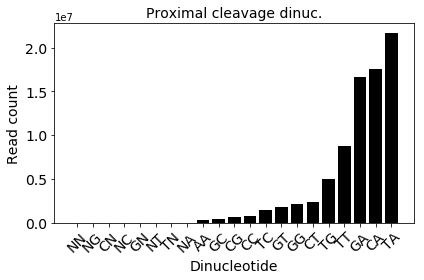

In [11]:
plot_cut_2mers(df, proximal_cuts)

In [12]:
import regex as re

#Filter dataframe and cut matrices

misprime_regexes = [
    re.compile(r"N"),
    re.compile(r"(AAAAAAAAAAAA){s<=2}"),
    re.compile(r"(AAAAAAAAAAAAAAAA){s<=4}"),
    re.compile(r"(AAAAAAAAAAAAAAAAAAAA){s<=5}")
]

keep_index = []
for index, row in df.iterrows() :
    if index % 100000 == 0:
        print("Read up to sequence: " + str(index))
    
    curr_seq = row['seq']
    curr_lib_index = row['library_index']
    
    internal_priming = False
    if curr_lib_index != 35 :
        for misprime_regex in misprime_regexes :
            if re.search(misprime_regex, curr_seq) :
                internal_priming = True
                break
    elif curr_lib_index == 35 and re.search(misprime_regexes[0], curr_seq) :
        internal_priming = True

    incorrect_pas = False
    if curr_lib_index == 30 and curr_seq[70:76] != 'AATAAA' :
        incorrect_pas = True
    elif curr_lib_index == 31 and curr_seq[70:76] != 'CATAAA' :
        incorrect_pas = True
    elif curr_lib_index == 32 and curr_seq[70:76] != 'AATAAA' :
        incorrect_pas = True
    elif curr_lib_index == 33 and curr_seq[70:76] != 'AATAAA' :
        incorrect_pas = True
    elif curr_lib_index == 34 and curr_seq[70:76] != 'AATAAT' :
        incorrect_pas = True
    elif curr_lib_index == 35 and curr_seq[70:76] != 'AATAAA' :
        incorrect_pas = True
    
    if not (internal_priming or incorrect_pas) :
        keep_index.append(index)


df_cleaned = df.iloc[keep_index].reset_index(drop=True)

proximal_cuts_cleaned = proximal_cuts[keep_index]

print(len(df_cleaned))
print(proximal_cuts_cleaned.shape[0])


Read up to sequence: 0
Read up to sequence: 100000
Read up to sequence: 200000
Read up to sequence: 300000
Read up to sequence: 400000
Read up to sequence: 500000
Read up to sequence: 600000
Read up to sequence: 700000
Read up to sequence: 800000
Read up to sequence: 900000
Read up to sequence: 1000000
Read up to sequence: 1100000
Read up to sequence: 1200000
Read up to sequence: 1300000
Read up to sequence: 1400000
Read up to sequence: 1500000
Read up to sequence: 1600000
Read up to sequence: 1700000
Read up to sequence: 1800000
Read up to sequence: 1900000
Read up to sequence: 2000000
Read up to sequence: 2100000
Read up to sequence: 2200000
Read up to sequence: 2300000
1899451
1899451


In [13]:
#Store dataframe and cut matrices
library_version = 'cleaned'

df_cleaned = df_cleaned[['seq', 'mask', 'proximal_count', 'distal_count', 'total_count', 'library', 'library_index', 'sublibrary', 'sublibrary_index']]

df_cleaned.to_csv(library_name + '_' + library_version + '.csv', header=True, index=False, sep=',')

spio.savemat(library_name + '_' + library_version + '_cuts', {'cuts' : proximal_cuts_cleaned})

In [14]:
#Read dataframe and cut matrices
library_version = 'cleaned'

df_cleaned = pd.read_csv(library_name + '_' + library_version + '.csv', delimiter=',').reset_index(drop=True)

proximal_cuts_cleaned = spio.loadmat(library_name + '_' + library_version + '_cuts.mat')['cuts']

print(len(df_cleaned))

1899451


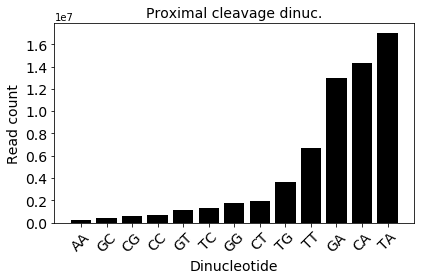

In [15]:
plot_cut_2mers(df_cleaned, proximal_cuts_cleaned)

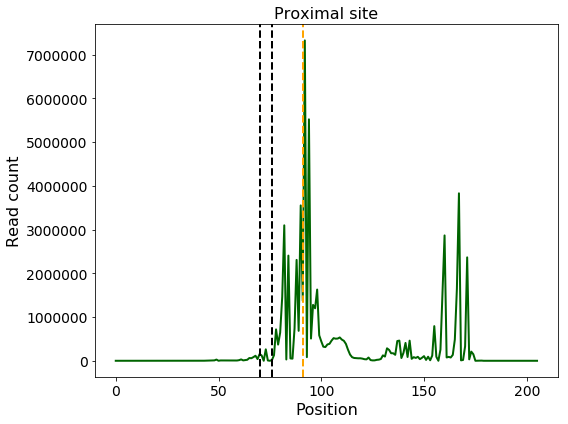

In [16]:

proximal_profile = np.ravel(proximal_cuts_cleaned.sum(axis=0))

f = plt.figure(figsize=(8, 6))

plt.plot(np.arange(len(proximal_profile)), proximal_profile, c='darkgreen', linewidth=2)

#Proximal 1
plt.axvline(x=70, linewidth=2, c='black', linestyle='--')
plt.axvline(x=70 + 6, linewidth=2, c='black', linestyle='--')
plt.axvline(x=70 + 21, linewidth=2, c='orange', linestyle='--')


plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Position', fontsize=16)
plt.ylabel('Read count', fontsize=16)
plt.title('Proximal site', fontsize=16)
plt.tight_layout()

plt.show()


In [17]:

#Filter final version on read count

total_count = np.array(df_cleaned['total_count'])
filter_index = np.nonzero(total_count >= 10)[0]

df_final = df_cleaned.iloc[filter_index].reset_index(drop=True)
proximal_cuts_final = proximal_cuts_cleaned[filter_index]

print(len(df_final))
print(proximal_cuts_final.shape[0])


1398135
1398135


In [18]:
#Store dataframe and cut matrices
library_version = 'final'

df_final = df_final[['seq', 'mask', 'proximal_count', 'distal_count', 'total_count', 'library', 'library_index', 'sublibrary', 'sublibrary_index']]

df_final.to_csv(library_name + '_' + library_version + '.csv', header=True, index=False, sep=',')

spio.savemat(library_name + '_' + library_version + '_cuts', {'cuts' : proximal_cuts_final})

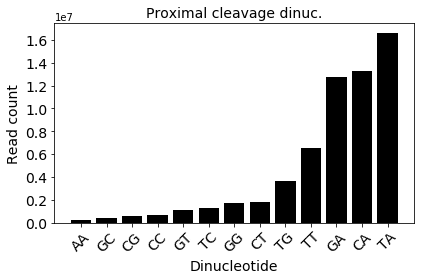

In [19]:
plot_cut_2mers(df_final, proximal_cuts_final)